In [1]:
##Segment Nuclei
import skimage.io as io
io.use_plugin('tifffile')

#Load image
im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1.tif')

#Slice1 contains ~58 nuclei, 52 not touching the border

#Select Hoechst stack
Hoechst_stack = im[:,:,:,0]

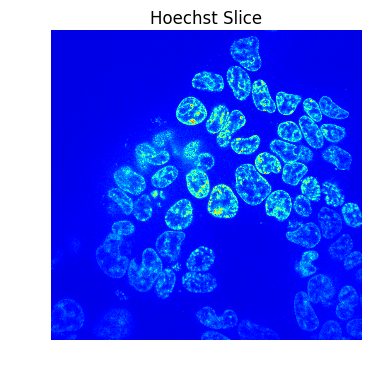

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(Hoechst_stack[4])
plt.axis('off')
plt.title('Hoechst Slice')

#Note uneven illumination

In [3]:
#Threshold the image
import mahotas as mh  #used for labelling binary regions

#[1] Mean
mask1=Hoechst_stack>Hoechst_stack.mean()

#[2] 3D Gaussian Filter then mean
smoothed_Hoechst_stack=mh.gaussian_filter(Hoechst_stack, 3)
shs_mean = smoothed_Hoechst_stack.mean()
mask2 = smoothed_Hoechst_stack > shs_mean

In [6]:
#[3] Try local threshold
#Must be a 2D array
from skimage.filters import threshold_otsu, threshold_adaptive
import numpy as np

mask3=np.zeros_like(Hoechst_stack)
block_size = 35 #Width of neighbourhood in pixels. Default was 35
offset = -20    #Constant subtracted from mean. Default was 10

for z, frame in enumerate(Hoechst_stack):
    mask3[z] = threshold_adaptive(frame, block_size, 'mean', offset)

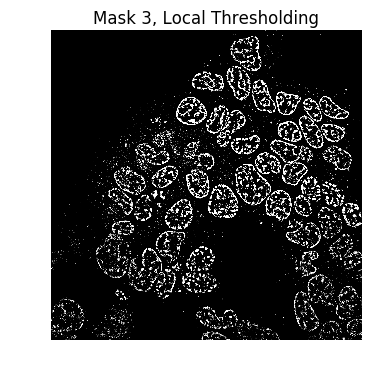

In [7]:
plt.imshow(mask3[4], cmap='gray')
plt.axis('off')
plt.title('Mask 3, Local Thresholding')

In [11]:
#[4] Try local Otsu (Slow)
#from skimage.morphology import disk
#from skimage.filters import threshold_otsu, rank
#from skimage.util import img_as_ubyte

#Select a single test image from the stack
img = Hoechst_stack[4]

radius = 50              #Default is 15, which looks good. 
                         #Tried nuclei size radius ~50, Bigger border around nuceli
                         #Tried nuclei size radius ~100. 
                         #Also tried r=5, worse for bright nuclei clustering
selem = disk(radius)

local_otsu = rank.otsu(img, selem)
local_otsu_mask= img >= local_otsu

#For comparison
#threshold_global_otsu = threshold_otsu(img)
#global_otsu = img >= threshold_global_otsu

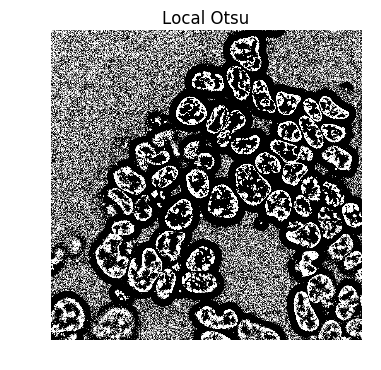

In [12]:
plt.imshow(local_otsu_mask, cmap='gray')
plt.axis('off')
plt.title('Local Otsu')

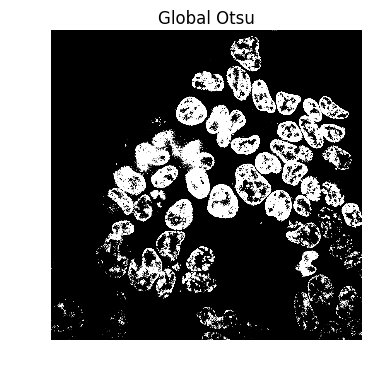

In [13]:
plt.imshow(global_otsu, cmap='gray')
plt.axis('off')
plt.title('Global Otsu')

In [14]:
#Try local otsu ----- THIS WILL BE VERY SLOW
#Must be a 2D array
mask4=np.zeros_like(Hoechst_stack)

radius = 50            #default is 15
selem = disk(radius)

for z, frame in enumerate(Hoechst_stack):
    print(z)
    local_otsu = rank.otsu(frame, selem)
    mask4[z] = frame >= local_otsu

In [56]:
##SAVE MASK4, IT TAKES FOREVER TO RUN
io.imsave('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Hoechst_Local_Otsu.tif', mask4)

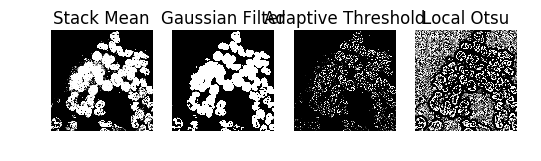

In [15]:
##Compare Threshold methods
images=[mask1, mask2, mask3, mask4]
titles=("Stack Mean", "Gaussian Filter", "Adaptive Threshold", "Local Otsu")

for x in range(len(images)):
    plt.subplot(1,4,x+1),plt.imshow(images[x][4],'gray')
    plt.subplot(1,4,x+1),plt.title(titles[x])
    plt.subplot(1,4,x+1),plt.axis('off')

In [ ]:
#Observations
#mask1 is too noisy
#mask2 bunches nuclei
#mask3 is noisy, but detects edges effectively, takes two parameters
#mask4 is bright and clean, but very slow on single images let alone large 3D stacks

In [ ]:
#Compare after fill_holes

## Process binary array frame by frame:
def fill_3D(array):
    stack=np.zeros_like(array)
    for z, frame in enumerate(array):
        filled = morphology.binary_fill_holes(frame).astype(int)
        stack[z] = filled
    return stack

In [ ]:
#Calculate filled masks for each technique
filled_masks=np.zeros_like(images)

for b in range(len(images)):
    filled=fill_3d(images[b])
    filled_masks[b]=filled

In [20]:
##Remove background by intersecting with 3D gaussian filter mask
mask5 = np.logical_and(mask2, mask4)

In [66]:
##Save mask5 binary array
np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Hoechst_Local_Otsu_3D_Gaussian_Intersect', mask5)

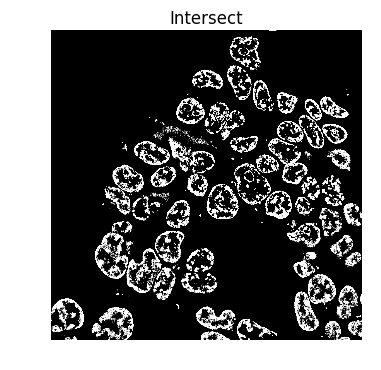

In [61]:
plt.imshow(mask5[10], cmap='gray')
plt.axis('off')
plt.title('Intersect')

In [36]:
##Open and close
from scipy.ndimage import morphology

binary_img=mask5

In [ ]:
##Iterate through hulls, dilate/fill/erode to give filled regions.


blob=morphology.binary_dilation(test, np.ones((20,20)))
filled_blob=morphology.binary_fill_holes(blob)
reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))

**Consider Reconstruct**


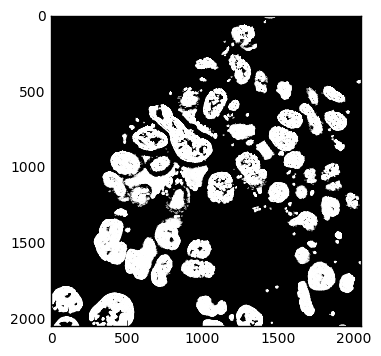

In [46]:
plt.imshow(binary_img[z], cmap=plt.cm.gray)
plt.contour(binary_img[z], [0.5], linewidths=1, colors='white')

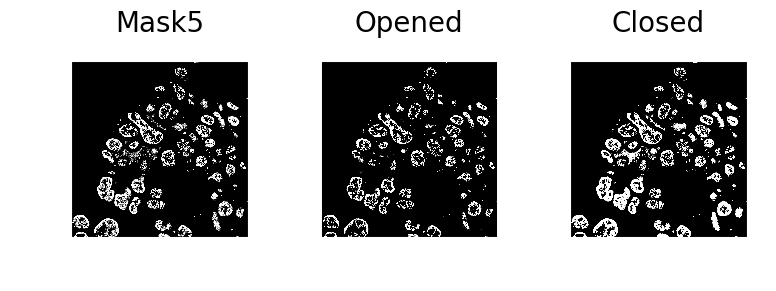

In [60]:
# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

z=22

ax1.imshow(mask5[z], cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Mask5', fontsize=20)

ax2.imshow(open_img[z], cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Opened', fontsize=20)

ax3.imshow(closed_img[z], cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Closed', fontsize=20)

fig.tight_layout()

plt.show()

In [30]:
##Find edges
#from skimage import feature

#Test on single image
edges1 = feature.canny(masked[4])
edges2 = feature.canny(masked[4], sigma=3)

#Detect edges with canny
#edges1 = feature.canny(mask5[4])
#edges2 = feature.canny(mask5, sigma=3)

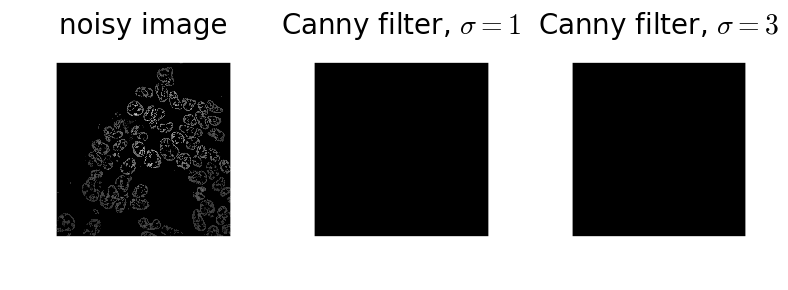

In [31]:
# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(masked[4], cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

In [29]:
##Long shot
masked=Hoechst_stack*mask5

In [47]:
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

In [50]:
##Find Circles

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(mask5[z], accuracy=20, threshold=250,
                       min_size=80, max_size=300)
result.sort(order='accumulator')

KeyboardInterrupt: 

In [ ]:
# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()